I recently got back into [Dungeon Crawl Stone Soup](https://crawl.develz.org/), a charming old-school roguelike. Not only is DCSS free and open source, it's a gift to an armchair data scientist like me, since it has a lot of publicly available gameplay data. Each completed game yields a 'morgue' file, which gives lots of information about the game, like what level the player reached, which god they worshipped, what was in their inventory, and so on. [Here's](http://crawl.akrasiac.org/rawdata/scone/morgue-scone-20161225-013224.txt) an example from one of my games.

I downloaded all the morgue files from one popular DCSS server, [http://crawl.akrasiac.org/](http://crawl.akrasiac.org/), and parsed out about a million games. My code is available on GitHub [here](https://github.com/colinmorris/crawl-coroner).

In this notebook, I'll be doing some analysis involving the 26\* different species that players choose from when starting a game.

\*(This data spans 10 major versions, from 0.10 to 0.20, some of which added or removed species. I'm including all extant species in the most recent release, 0.19. This excludes species removed between 0.10 and 0.19 like sludge elves, and experimental species like lava orcs and barachians. It includes high elves, even though they're set to be removed in 0.20.)

In [2]:
%matplotlib inline
from __future__ import division
from vis_common import load_frame, STORE
from crawl_data import CANON_SPECIES
from plotting_helpers import xlabel_pct, ylabel_pct, plot_percent
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import IPython.core.display as di

f = load_frame(include=['saw_temple', 'saw_lair', 'saw_vaults', 'saw_zot'])
print "Loaded data frame with {} records and {} columns".format(len(f), len(f.columns))

# Some reusable indices. These are just boolean arrays I can use to index into my data
# frame to get games that were lost, or won, or quit
ilost = STORE['ilost']
iwon = STORE['iwon']
iquit = STORE['iquit']

species = f['species'].cat.categories
drac_species = [sp for sp in species if 'draconian' in sp]
idrac = f['species'].isin(drac_species)
colored_dracs = [sp for sp in drac_species if sp != 'draconian']
cdrac_index = f['species'].isin(colored_dracs)

def get_original_species(sp):
    return 'draconian' if sp in drac_species else sp
    
# The draconian species presents a little problem. When draconians hit level 7, they 
# get a random colour, and their species label changes accordingly. We'd rather lump
# black/red/green/baby draconians all into one species, or we'll get some funny results.
# (For example, the win rate for coloured draconians is very high, because of the survivor
# bias. On the other hand, baby draconians win 0% of the time, because it's basically 
# impossible to win the game before level 7.)
f['orig_species'] = f['species'].map(get_original_species)

Loaded data frame with 1295053 records and 16 columns


## Pick rate

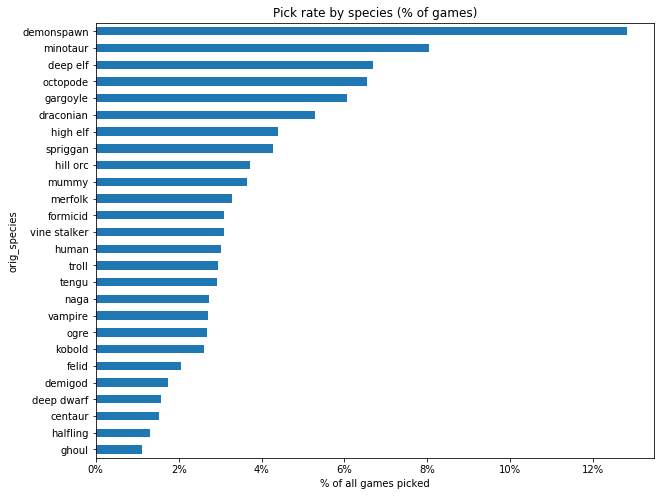

In [24]:
pr = (f.groupby('orig_species').size() / len(f)).sort_values()
ax = plot_percent(pr, True, title='Pick rate by species (% of games)', figsize=(10,8));
ax.set_xlabel('% of all games picked');

The most surprising thing here to me was just how much demonspawn exceed every other species in popularity. They're almost twice as popular as the second-place species, with an absolute difference of around 40,000 games.

The popularity of minotaurs and deep elves isn't too surprising, since they're the archetypal melee fighter and caster species, respectively. There's maybe some tendency for species with complex mechanics or heavy restrictions to be less popular, but there are lots of exceptions. (Halflings are very vanilla, and unpopular, and mummies, spriggans, and octopodes are weird but popular)

## Win rate

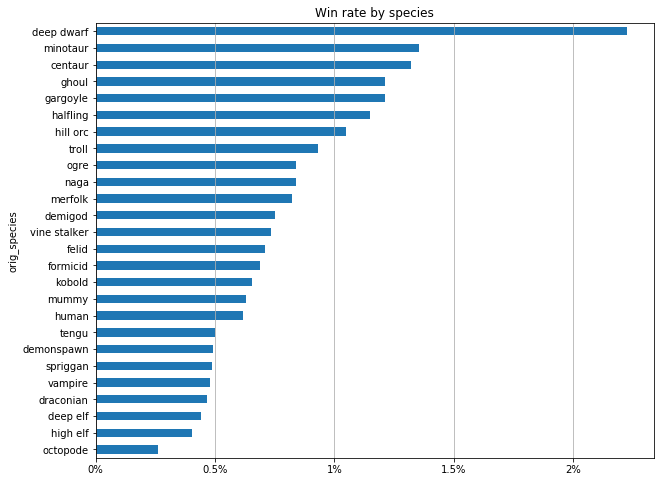

In [25]:
wr = f.groupby('orig_species')['won'].mean().sort_values()
ax = plot_percent(wr, True, title='Win rate by species', figsize=(10,8))
ax.grid(axis='x');

There's quite a lot of variation here. A random deep dwarf game is 10x as likely to be won as a random octopode game. What makes good species good and bad species bad? I'm going to focus on the two extremes cases to start.

## Why do deep dwarves win so much?

### Hypothesis 1: Pakellas abuse

When I showed these results to a friend who plays DCSS, he suggested that maybe this was an effect of the god Pakellas being overpowered. Deep dwarves would benefit disproportionately from worshipping Pakellas because of their high evocation aptitude, and the ability to recharge Heal wounds wands to overcome their lack of HP regeneration.

Pakellas was added in 0.18 and removed in 0.19, so if this is the reason, we would expect their win rate to be higher in version 0.18, and for most of their wins to come from that version.

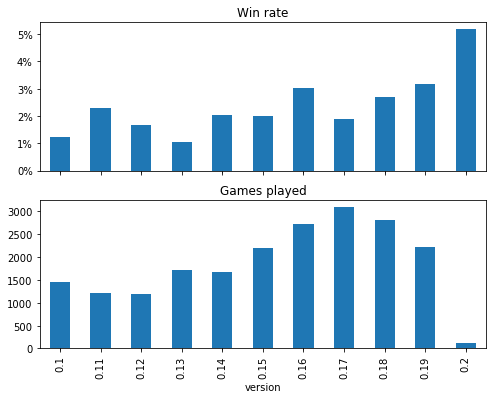

In [26]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(8,6))
idd = f['species'] == 'deep dwarf' # reusable index
dd_winr = f[idd].groupby('version')['won'].mean()
dd_plays = f[idd].groupby('version').size()
plot_percent(dd_winr, ax=ax1, title="Win rate")
dd_plays.plot.bar(ax=ax2, title="Games played");

**Nope!** Their win rate is actually kinda low in 0.18. Well what if most of these DDs are secretly bots? 

### Hypothesis 2: Deep Dwarf bots

It turns out that, as crushingly difficult as DCSS is, there exists at least one bot that can beat it. Elliptic's [qw](https://github.com/elliptic/qw) bot can apparently win 15% of games with its best combination, Deep Dwarf(!) fighter of Makhleb.

qw leaves some distinctive patterns in the notes section. By looking for them, I was able to positively id on the order of 10,000 bot games. Those games are excluded from the data I'm analyzing here, but I can't be totally certain there don't exist other bots, or variants of qw that don't leave these patterns. 

One hallmark of bots is that they play really fast. Let's plot turns taken against wallclock time, and see if there's a noticeable difference between DDs and non-DDs.

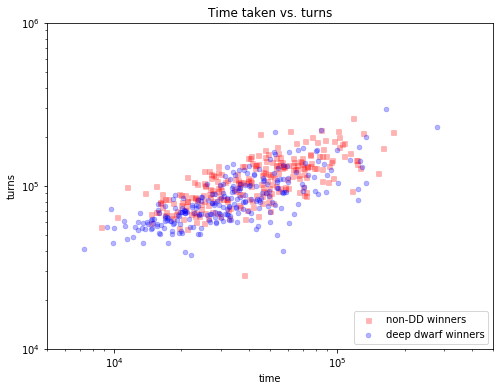

In [27]:
s = 25
alpha = 0.3
n = 250
lw=.5
def plot_turn_time(figsize=(8,6)):
    ax = f.loc[iwon & ~idd].head(n)\
        .plot.scatter(x='time', y='turns', color='red', marker="s", figsize=figsize, loglog=1,
                      label='non-DD winners', alpha=alpha, s=s, lw=lw);
    f.loc[iwon & idd].head(n)\
        .plot.scatter(x='time', y='turns', color='blue', label='deep dwarf winners',
                      marker="o", alpha=alpha, s=s, lw=lw, ax=ax)

    l, r = 5*10**3, 5 * 10**5
    b, t = 10**4, 10**6
    ax.set_xlim(l, r)
    ax.set_ylim(b, t)
    ax.legend(loc=4);
    ax.set_title("Time taken vs. turns")
    return ax
plot_turn_time();

(Note the log-log scale, and the truncated axes.)

Looks pretty well mixed. If anything, DDs seem to be a little slower, with respect to turns taken per second.

Just to make it really clear, let's load up some known bot games and add them to the mix.

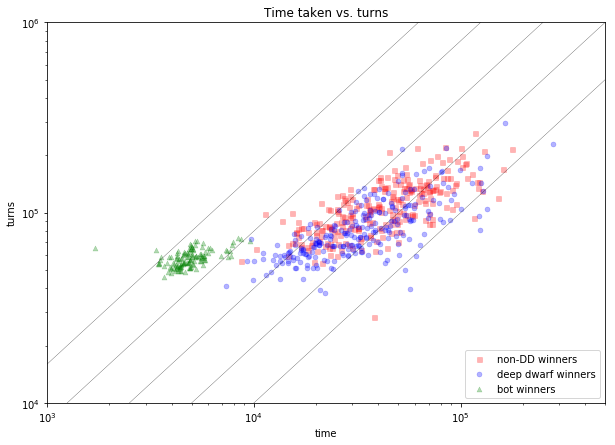

In [28]:
bots = STORE['bots']
ax = plot_turn_time((10,7))
bots.loc[iwon].head(n)\
    .plot.scatter(x='time', y='turns', color='green', label='bot winners',
                  marker="^", alpha=alpha, s=s, lw=lw, ax=ax)

l, r = 10**3, 5 * 10**5
b, t = 10**4, 10**6
ax.set_xlim(l, r)
ax.set_ylim(b, t)
for turns_per_second in [1, 2, 4, 8, 16]:
    ax.plot(
        [l, t/turns_per_second],
        [l*turns_per_second, t],
        color='black', lw=lw/2,
    )
ax.legend(loc=4);

The diagonal lines represent, from left to right, 16/8/4/2/1 turns taken per second. The bots are clearly in a league of their own here. When they win, they win in a small number of turns and a *really* small amount of time (I had to move the x-axis back to make that one bot with the ~20 minute time visible - it was literally off the chart).

### Hypothesis 3: Newb reppelent

My best guess is just that deep dwarves are unattractive to inexperienced players. Not being able to regenerate HP is really scary. So DD games are skewed towards experienced players, who are more likely to win (no matter what species they're playing). 

We could try to test this directly, but it'd be tricky. Number of games played is going to be a poor approximation of level of experience, because lots of users will have played DCSS locally (or on another server, or under another username), before playing their first CAO game. 

But this hypothesis is at least partially supported by the earlier chart of species pick rate, which showed DDs as the 4th least picked species. Does a general relationship hold between a species' popularity and its win rate? Let's make a scatterplot!

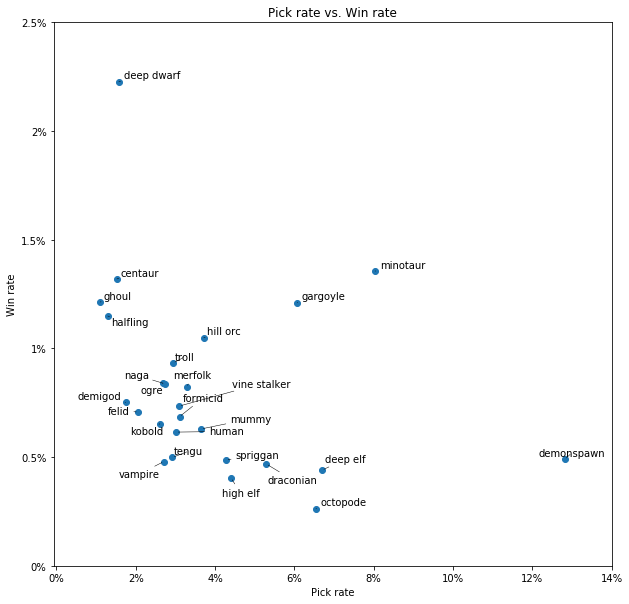

In [146]:
from adjustText import adjust_text
sp = pr.index
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(pr.values, wr[sp].values)
texts = [plt.text(pr.loc[species], wr.loc[species], species) for species in sp]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=.5), force_points=.7, force_text=.3)
ax.set_title("Pick rate vs. Win rate")
ax.set_xlabel('Pick rate')
xlabel_pct(ax)
ax.set_ylabel('Win rate');
ax.set_ylim(bottom=0, top=0.025)
ylabel_pct(ax)

There does seem to be a weak correlation here. Demonspawn, the most played class, has a poor win rate. Octopodes, the species with the lowest win rate, is in the top 5 most picked. Centaurs, ghouls, and deep dwarves are very unpopular and win a lot.

The two big exceptions are minotaurs and gargoyles, which are very popular and have a high win rate. 

## Why do octopodes suck?

At around 1 in 400, octopodes have the lowest win rate of any species. 

We could make the claim that, whereas DDs are a newb repellent, Octopodes are a newb magnet. "8 rings? Cool!". And they are quite popular. 

But let's try to dig a bit deeper. How and when do octopodes meet their demise?

In [ ]:
# Kinda slow. Probably a more efficient way to do this, without looping. 
# I wish the pandas group by documentation was better.
dr_given_level = []
ioct = f['species'] == 'octopode'
for lvl in range(1, 28):
    dr_given_level.append( (~ioct & ilost & (f['level'] == lvl)).sum() / 
                          (0.0+(~ioct & (f['level'] >= lvl)).sum()) )
# TODO: download more RAM
import gc; gc.collect()
oc_dr_given_level = []
for lvl in range(1, 28):
    oc_dr_given_level.append( (ilost & (f['level'] == lvl) & ioct).sum() / 
                          (0.0+((f['level'] >= lvl) & ioct).sum()) )
gc.collect();

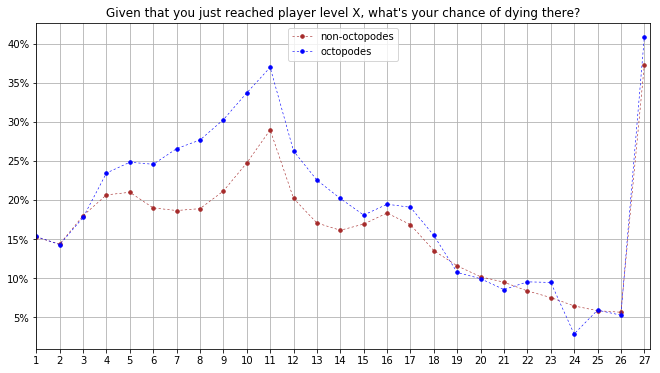

In [134]:
fig, ax = plt.subplots(figsize=(11,6))
common_kwargs = dict(marker='.', markersize=7, linestyle=':', lw=.6)
ax.plot(np.arange(1,28), dr_given_level, color='brown', label='non-octopodes', **common_kwargs)
ax.plot(np.arange(1,28), oc_dr_given_level, color='b', label='octopodes', **common_kwargs)
ax.legend(loc=9)
ax.set_xlim(1, 27.25);
ax.set_xticks(range(1,28))
ylabel_pct(ax)
ax.set_title("Given that you just reached player level X, what's your chance of dying there?");
ax.grid(axis='both')

The first three levels are about as deadly for octopodes as for anyone else. But the death rate diverges massively at level 4 and doesn't equalize until the mid to late teens. It takes a long time to fill 8 ring slots! 

(Aside: The huge bump at level 11, and the lesser one around 16/17 are both interesting. I think the first bump corresponds to when most players enter the lair, and the second corresponds to when players start venturing into rune branches. I'll go into more of this stuff in another post.)

This suggests octopodes are pretty decent in the mid-to-late game, but frequently die before they can get there.

The dramatic jump at level 27 makes sense. Because it's the level cap, players spend a lot more time at level 27 than they do at any other level, so it presents a lot more opportunities to die. 

What's less clear is why level 27 is almost 5% more deadly for octopodes, after they managed to stay about even with other species since the mid-to-late teens. Aren't octopodes a good late game species?

Maybe too late-game for their own good!

### Ambitious octopodes

One factor that may affect a species' win rate is the rate at which they tend to seek more than 3 runes. Let's see how often each species goes into the extended game.

In particular, let's measure: given that a player of species X earned 3 runes, how likely were they to continue on to earn more than 5 runes?

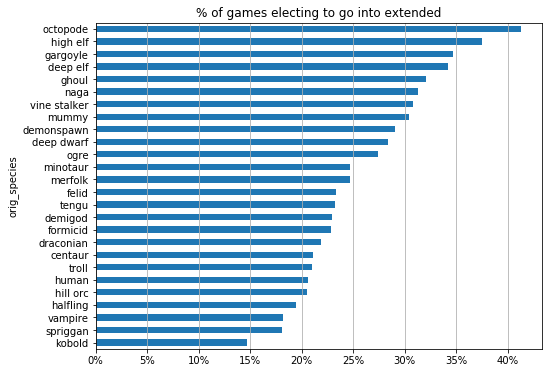

In [136]:
extended = f.loc[f['nrunes'] > 5].groupby('orig_species').size()
ax = (extended / f.loc[f['nrunes'] >= 3].groupby('orig_species').size()).sort_values()\
 .plot.barh(title='% of games electing to go into extended', figsize=(8,6));
xlabel_pct(ax)
ax.grid(axis='x');

Well, I'm starting to understand octopodes' abysmal win rate. They die like goldfish for most of the early-to-mid game, and when they do manage to get their tentacles on 3 runes, half the time they continue on to the most dangerous branches in the game. Presumably there are lots of octopodes who *could* have easily won with 3 runes, but ended up as an ink-blot on the floor of pandemonium. 

In [33]:
octo_death_places = f.loc[ilost & (f['species'] == 'octopode') & (f['level'] > 24)].groupby('wheredied').size()
octo_death_places.name = 'octopodes'
human_death_places = f.loc[ilost & (f['species'] == 'kobold') & (f['level'] > 24)].groupby('wheredied').size()
human_death_places.name = 'kobolds'
dp = pd.concat([octo_death_places, human_death_places], axis=1)
print "Where do octopodes/kobolds die after level 24?"
print dp.select(lambda i: dp.loc[i].sum() > 10).sort_values(by='octopodes', ascending=0)

Where do octopodes/kobolds die after level 24?
               octopodes  kobolds
wheredied                        
ziggurat              32        8
pits of slime         28       17
realm of zot          23       55
pandemonium           22       15
tomb                  16        9
vaults                15       28
depths                11       20
dungeon                7        5
abyss                  6       12
crypt                  4        7


A higher % of kobolds who make it to level 25 will win than octopodes, but the kobolds who fail to win from that position mostly die in Zot trying to get the orb. The octopodes who fail to win from that point mostly die in exotic extended game locales like ziggurats.

## Controlling for number of runes sought

It seems like the variation in ambition across species makes our table of win rates harder to interpret. Let's try to control for this. What's the win rate for each species, *in a world where players always go for just 3 runes*?

We can calculate this counterfactual as:

    P(earning >= 3 runes | species) * P(success | species, trying to win with 3 runes)

The first term we can easily calculate directly from the data. The second term is more tricky: the chance of a given species winning given that they've already earned 3 runes, and given that they don't intend to get any more. It's tricky because it involves a latent variable: the player's intentions. But we can approximate it as:

    #(3 rune wins | species) / 
      (#(3 rune wins | species) + #(deaths in Zot, the depths, and the dungeon | species, 3 runes))
                             
The denominator should be a pretty good approximation of the number of 3-rune win attempts by a given species. We can't just count the number of deaths by characters holding 3 runes, because that will include lots of deaths that occurred while trying to get a 4th rune in the slime pits, the abyss, etc. We only want to count deaths that occurred while diving down to Zot to get the orb, or while ascending back up to D:1 with the orb.  

(This may slightly undercount, since some 3 rune win attempts may end in the Vaults/Shoals/Swamp/etc. whilst trying to get back up to the dungeon with the third rune, especially if it was "ninja'd". They may also occasionally end in the abyss as a result of being banished on the way to the orb.)

Here's a graph just showing the value of that second term for each species:

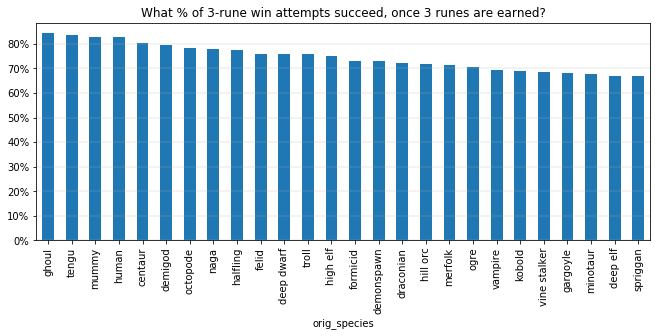

In [137]:
geq_three_runes = f[f['nrunes']>=3].groupby('orig_species').size()

three_rune_wins = f.loc[iwon & (f['nrunes']==3)].groupby('orig_species').size()
three_rune_deathspots = ['dungeon', 'realm of zot', 'depths']
three_rune_win_attempts = (three_rune_wins + 
    f[(f['nrunes']==3) & f['wheredied'].isin(three_rune_deathspots)].groupby('orig_species').size())

zot_success = three_rune_wins / three_rune_win_attempts
ax = plot_percent(zot_success.sort_values(ascending=False), figsize=(11,4), 
             title="What % of 3-rune win attempts succeed, once 3 runes are earned?")
ax.grid(axis='y', lw=.3);

A pretty small spread, relatively speaking. Let's see the full adjusted win rates.

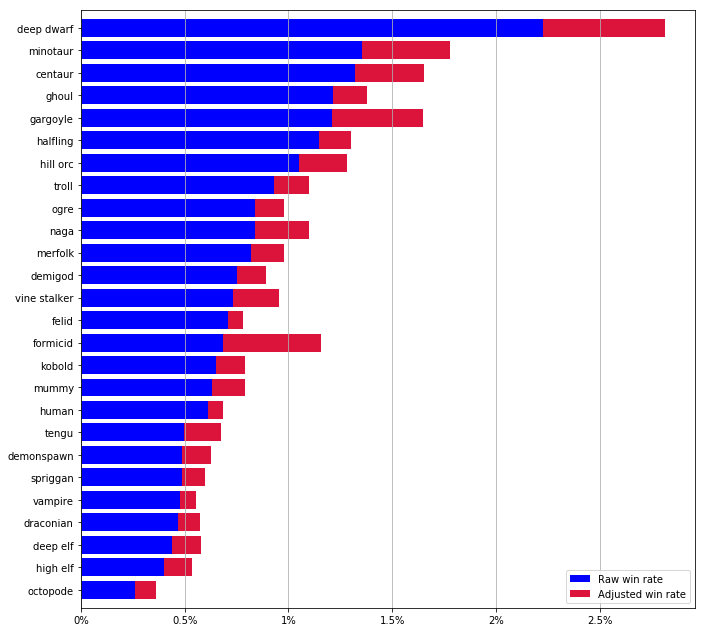

In [140]:
adjusted_wr = (geq_three_runes / f.groupby('orig_species').size()) * zot_success
wr2 = wr
fig, ax = plt.subplots(figsize=(11,11))
x = range(len(wr2.index))
ax.barh(x, wr2.values, label="Raw win rate", color="b", zorder=1)
ax.barh(x, adjusted_wr.loc[wr2.index].values, label="Adjusted win rate", color="crimson", zorder=0)
ax.legend()
ax.set_ylim(-.8, len(x)-.2)
ax.set_yticks(x)
ax.set_yticklabels(wr2.index)
ax.grid(axis='x')
xlabel_pct(ax);

The new red bars represent each species' hypothetical win rate if players always tried to win as soon as they had 3 runes. In some sense, this should be a fairer measure by which to compare species' power.

Popular 15-rune species like gargoyles and especially formicids go up a few ranks. For species like felids and vampires that were already doing mostly 3-rune runs, the adjusted win rate is not much higher than their raw win rate, so they drop a few ranks. 

Relative to their original win rate, octopodes get a pretty big bump (their 3-rune win rate is the 7th highest), but they're still a solid dead last. It looks like it's their early game fragility that accounts for their low win rate, more so than their tendency to go for 15 runes.

## Win rates at different stages of the game

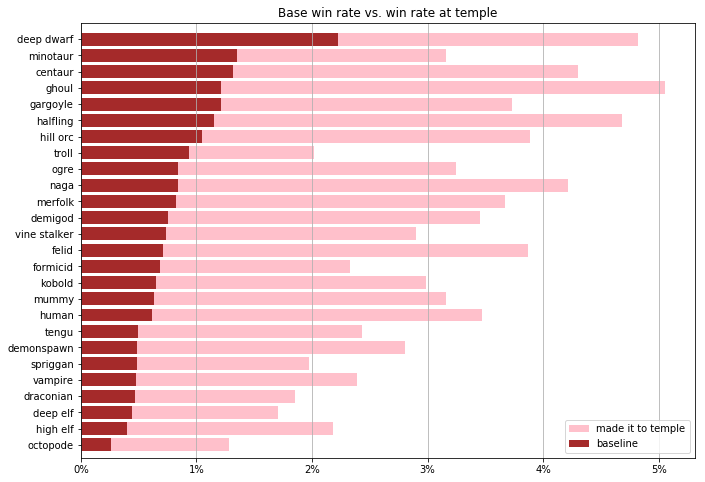

In [36]:
w = .8
fig, ax = plt.subplots(figsize=(11,8))
temple_wr = f[f['saw_temple'] == True].groupby('orig_species')['won'] .mean().dropna()[wr.index]
for label, df, color in [('made it to temple', temple_wr, 'pink'), ('baseline', wr, 'brown')]:
    ax.barh(np.arange(len(df.index)), df.values, w, label=label, color=color)
ax.set_ylim(-w, len(wr))
ax.set_yticks(np.arange(len(wr)))
ax.set_yticklabels(wr.index)
xlabel_pct(ax)
ax.set_title("Base win rate vs. win rate at temple")
ax.grid(axis='x')
ax.legend(loc=4);


The brown bars here are our familiar win-rates from before, but the pink bars are new: they show what % of games each species wins *given that it reaches the ecumenical temple*.

A disproportionately small pink bar (like the one on trolls), suggests that this species has a strong early game. Getting to the temple doesn't much increase their chance of winning, because they were expecting to make it to the temple. A large pink bar (e.g. ghoul, naga), suggests that going from D:1 to the temple is a significant filter for this species.

Let's throw in a few more milestones: the lair, the vaults, and the realm of zot.

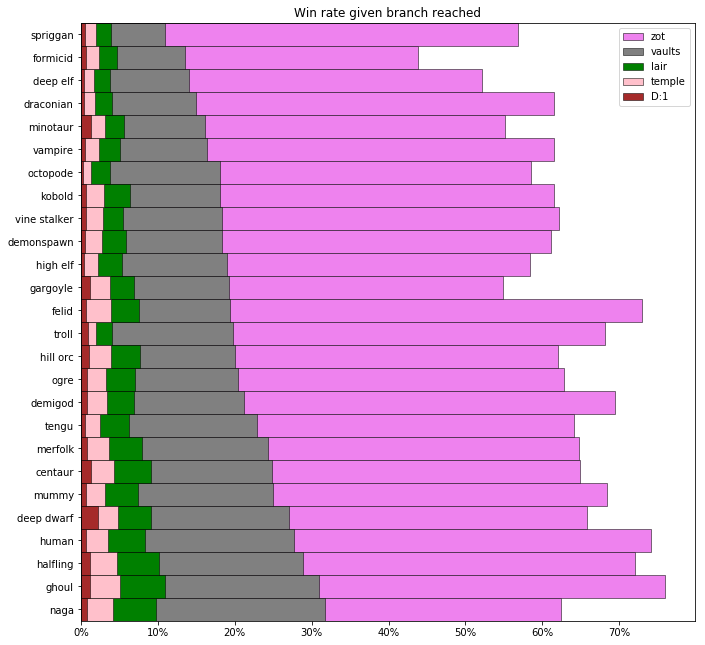

In [141]:
width = 1
fig, ax = plt.subplots(figsize=(11,11))
colours = ['brown', 'pink', 'green', 'grey', 'violet']
branches = ['D:1', 'temple', 'lair', 'vaults', 'zot']
# Order species by win rate given vaults
sp = f[f['saw_vaults']==True].groupby('orig_species')['won'].mean().sort_values(ascending=0).index
ranked = []
for branch, colour in reversed(zip(branches, colours)):
    if branch == 'D:1':
        df = f
    else:
        df = f[f['saw_'+branch] == True]
    branch_wr = df.groupby('orig_species')['won'].mean()[sp]
    ax.barh(range(len(branch_wr.index)), branch_wr.values, 
           width, label=branch, color=colour, linewidth=.5, edgecolor='black',
          )
    ranked.append(branch_wr.sort_values(ascending=0).index)
ranked.reverse()
ax.set_title("Win rate given branch reached")
ax.set_yticks(np.arange(len(branch_wr.index)))
ax.set_ylim(-.5, len(branch_wr.index)-.5)
ax.set_yticklabels(branch_wr.index)
xlabel_pct(ax)
ax.legend();

This time species are sorted by their win rate given that the vaults are reached (the grey bars).

The table below might make it easier to see how species go up and down in win rate at different stages of the game - it shows only species' ranking relative to one another.

In [38]:
ranked = np.asarray(ranked).T
cm = plt.get_cmap('jet')
color_indices = np.linspace(0, 1, ranked.shape[0])
canon_sort = list(ranked.T[0])
alpha = .3
def color_species(sp):
    # I think maybe this can be accomplished with style.background_gradient, but I wrote this before seeing it.
    i = canon_sort.index(sp)
    ctup = cm(color_indices[i])[:-1]
    csstup = tuple(map(lambda x: int(x*255), ctup)) + (alpha,)
    return ';'.join(['background-color: rgba{}'.format(csstup),
                    'text-align: center',
                    'font-size: 16px',
                     'padding: .3em, .6em',
            ])
                              
df = pd.DataFrame(ranked, columns=branches)
s = df.style\
    .applymap(color_species)\
    .set_caption('Species ranked by win rate given milestone reached')

# Hack to avoid obscure rendering issues with the HTML generated by 
# pandas' style.render() (not XHTML compliant) and kramdown
from BeautifulSoup import BeautifulSoup as BS
def sanitize_style(s):
    soup = BS(s.render())
    return soup.prettify()
    
di.display(di.HTML(sanitize_style(s)))

,D:1,temple,lair,vaults,zot
0,deep dwarf,ghoul,ghoul,naga,ghoul
1,minotaur,deep dwarf,halfling,ghoul,human
2,centaur,halfling,naga,halfling,felid
3,ghoul,centaur,centaur,human,halfling
4,gargoyle,naga,deep dwarf,deep dwarf,demigod
5,halfling,hill orc,human,mummy,mummy
6,hill orc,felid,merfolk,centaur,troll
7,troll,gargoyle,hill orc,merfolk,deep dwarf
8,ogre,merfolk,felid,tengu,centaur
9,naga,human,mummy,demigod,merfolk


Species that move up in rank (like tengu, octopodes, and ghouls), tend to be weak in the early game, and more powerful in the late game.

Species that move down in rank (like spriggans, formicids, minotaurs, and trolls) generally have a more powerful early game.

This also comes back to the number of runes each species tends to seek. Species like gargoyles and formicids may have a relatively low win rate given that they've seen the entrance to zot, not because they have a weak late game and are in danger of dying in zot, but because they have a high risk of dying in pan or hell, compared to a felid/human/vampire who's probably going for 3 runes. (Gargoyles and formicids are the two species that got the largest increase when we calculated adjusted win rates, assuming only 3-rune games.)

## Which draconian colour is best?

When draconians reach level 7, they're assigned one of 9 colours, each of which has different skill aptitudes, and a unique breath ability. There has been some debate on the forums about which colour is best:

- [Rank the draconian colors](https://crawl.develz.org/tavern/viewtopic.php?f=5&t=10176&p=140405)
- [Tier list: Draconian colors](https://crawl.develz.org/tavern/viewtopic.php?f=17&t=19271&p=261183)
- [Buff certain draconian colors](https://crawl.develz.org/tavern/viewtopic.php?f=8&t=20683&p=279050)

Let's see if we can use data to answer this question.

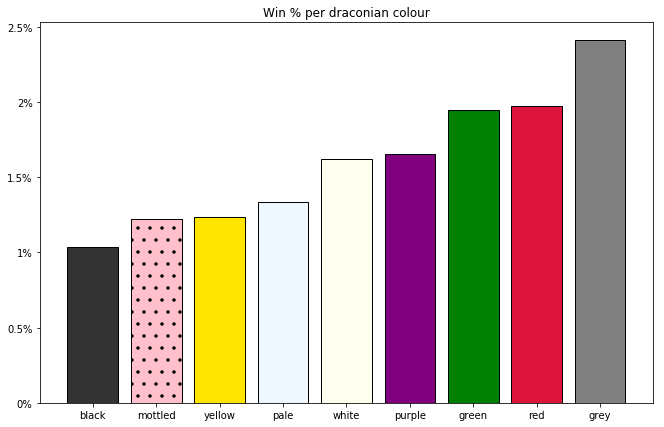

In [142]:
fig, ax = plt.subplots(figsize=(11,7))
colours = [(.2,.2,.2), 'pink', (1,.9,0), 'aliceblue', 'ivory', 'purple', 'green', 'crimson', 'grey']
color_winrates = f[cdrac_index].groupby('species')['won'].mean().dropna().sort_values()
xrange = np.arange(len(colours))
labels = [name.split()[0] for name in color_winrates.index]
bars = ax.bar(xrange, color_winrates.values, 
               color=colours, tick_label=labels, 
              edgecolor='black', lw=1,
              )
bars[1].set_hatch('.')
ylabel_pct(ax)
ax.set_title('Win % per draconian colour');

**\#justiceforblackdraconians**

Wait, but are these differences statistically significant?

If you have a burning curiosity about this question or just want to enjoy watching a mediocre mind struggle to understand the intricacies of statistical hypothesis testing, check out [my companion post](/blog/dcss_draconians) on the subject.